# Loading Data

In [1]:

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

def parse_orderbook_entry(entry):
    """
    Parse a single order book snapshot entry (dict) and extract:
      - timestamp
      - best bid price and volume
      - best ask price and volume
      - mid price
      - average volume (calculated from all bid and ask quantities)
    Returns a dictionary or None if data is missing.
    """
    if "bids" not in entry or "asks" not in entry:
        return None
    
    bids = entry["bids"]
    asks = entry["asks"]
    if not bids or not asks:
        return None  # no valid bids/asks

    # Best bid = highest bid price
    best_bid = max(bids, key=lambda x: x["p"])
    best_bid_price = best_bid["p"]
    best_bid_volume = best_bid["q"]
    
    # Best ask = lowest ask price
    best_ask = min(asks, key=lambda x: x["p"])
    best_ask_price = best_ask["p"]
    best_ask_volume = best_ask["q"]

    # Mid price: average of best bid and best ask prices.
    mid_price = (best_bid_price + best_ask_price) / 2

    # Calculate average volume across all bids and asks.
    avg_bid_volume = np.mean([order["q"] for order in bids])
    avg_ask_volume = np.mean([order["q"] for order in asks])
    avg_volume = (avg_bid_volume + avg_ask_volume) / 2

    return {
        "timestamp": entry["timestamp"],  # To be converted to datetime later
        "best_bid_price": best_bid_price,
        "best_ask_price": best_ask_price,
        "mid_price": mid_price,
        "best_bid_volume": best_bid_volume,
        "best_ask_volume": best_ask_volume,
        "avg_volume": avg_volume
    }

def load_orderbook_data(file_path):
    """
    Reads a data.json file where each line is one JSON snapshot.
    Returns a pandas DataFrame with:
      - timestamp (as DateTime index),
      - best_bid_price, best_ask_price, mid_price,
      - best_bid_volume, best_ask_volume, and avg_volume.
    """
    records = []
    with open(file_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            entry = json.loads(line)
            parsed = parse_orderbook_entry(entry)
            if parsed is not None:
                records.append(parsed)
    
    if not records:
        raise ValueError(f"No valid orderbook entries found in {file_path}")

    df = pd.DataFrame(records)
    
    # Convert 'timestamp' to DateTime (adjust the unit if needed)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ns')
    df.set_index('timestamp', inplace=True)
    df.sort_index(inplace=True)
    
    return df

def load_instrument_orderbooks(base_dir, instrument="BTC"):
    """
    Recursively walk through base_dir, find any folder named 'instrument',
    and load its 'data.json'. Concatenate all into a single DataFrame.
    """
    all_dfs = []
    for root, dirs, files in os.walk(base_dir):
        if os.path.basename(root) == instrument:
            data_file = os.path.join(root, "data.json")
            if os.path.isfile(data_file):
                df_instrument = load_orderbook_data(data_file)
                all_dfs.append(df_instrument)
    if not all_dfs:
        raise ValueError(f"No data.json files found for {instrument} in {base_dir}")
    final_df = pd.concat(all_dfs).sort_index()
    return final_df

def load_all_instruments(base_dir):
    """
    Recursively walk through base_dir and load data.json files for ALL instruments.
    Each subfolder that has a data.json is considered an instrument folder.
    The instrument name is added as a new column.
    
    Returns:
      A single pandas DataFrame containing all instruments' data,
      with an additional 'instrument' column.
    """
    all_dfs = []
    for root, dirs, files in os.walk(base_dir):
        if 'data.json' in files:
            data_file = os.path.join(root, 'data.json')
            instrument_name = os.path.basename(root)
            df_instrument = load_orderbook_data(data_file)
            df_instrument['instrument'] = instrument_name
            all_dfs.append(df_instrument)
    if not all_dfs:
        raise ValueError(f"No data.json files found in {base_dir}")
    final_df = pd.concat(all_dfs).sort_index()
    return final_df

# Example usage:
base_directory = "sample_dataset/BINANCE_SPOT"
df_all = load_all_instruments(base_directory)

# Inspect the combined DataFrame
print(df_all.head())
print(df_all.tail())
print("Number of rows:", df_all.shape[0])
print("Unique instruments found:", df_all['instrument'].unique())


def backtest(trades, initial_capital=10000):
    """
    Compute performance metrics based on a list of trades.
    
    Parameters:
      trades         : List of trades in the form
                       (entry_time, exit_time, entry_price, exit_price, direction)
      initial_capital: Starting portfolio value.
      
    Returns:
      metrics      : Dictionary containing total return, max drawdown, Sharpe ratio,
                     win/loss ratio, and number of trades.
      equity_curve : pandas Series of the portfolio value over time (at trade exit times).
    """
    # Calculate trade returns based on trade direction.
    trade_returns = []
    for (_, _, entry_price, exit_price, direction) in trades:
        if direction == 1:  # long
            r = (exit_price - entry_price) / entry_price
        elif direction == -1:  # short
            r = (entry_price - exit_price) / entry_price
        else:
            r = 0
        trade_returns.append(r)
        
    total_return = np.prod([1 + r for r in trade_returns]) - 1

    wins = [r for r in trade_returns if r > 0]
    losses = [r for r in trade_returns if r <= 0]
    win_loss_ratio = len(wins) / len(losses) if losses else np.nan

    equity = [initial_capital]
    equity_times = []
    for (_, exit_time, _, _, _), r in zip(trades, trade_returns):
        equity.append(equity[-1] * (1 + r))
        equity_times.append(exit_time)
    equity_curve = pd.Series(equity[1:], index=equity_times)

    rolling_max = equity_curve.cummax()
    # set precision to 10 decimal places to avoid division by zero
    rolling_max = rolling_max.round(10)
    drawdown = (rolling_max - equity_curve) / rolling_max
    max_drawdown = drawdown.max()

    if len(trade_returns) > 1:
        sharpe_ratio = (np.mean(trade_returns) / np.std(trade_returns)) * np.sqrt(len(trade_returns))
    else:
        sharpe_ratio = np.nan

    metrics = {
        'total_return': total_return,
        'max_drawdown': max_drawdown,
        'sharpe_ratio': sharpe_ratio,
        'win_loss_ratio': win_loss_ratio,
        'num_trades': len(trade_returns)
    }
    
    return metrics, equity_curve

            best_bid_price  best_ask_price  mid_price  best_bid_volume  \
timestamp                                                                
1990-01-01            1199            1200     1199.5            92145   
1990-01-01           16896           16897    16896.5           211529   
1990-01-01            3394            3395     3394.5             4690   
1990-01-01         9618649         9618650  9618649.5           879884   
1990-01-01          266299          266300   266299.5           343055   

            best_ask_volume  avg_volume instrument  
timestamp                                           
1990-01-01            35792  141575.300       RUNE  
1990-01-01           149658  260150.800        SOL  
1990-01-01              830    9686.350     PENDLE  
1990-01-01            20920   30949.125        BTC  
1990-01-01           334299   39880.100        ETH  
                         best_bid_price  best_ask_price  mid_price  \
timestamp                               

# Final Strategy (using price and volume indicators)

Instrument: RUNE
Total Return (in %): 12.96
Max Drawdown (in %): 1.15
Sharpe Ratio: 3.78
Win/Loss Ratio: 1.44
Number of Trades: 178
-------------------------------------------------


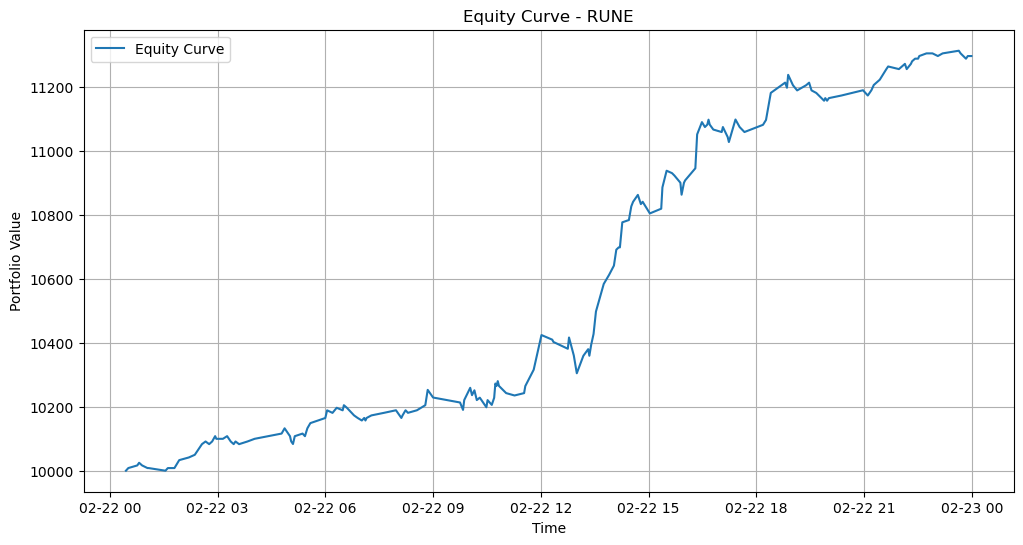

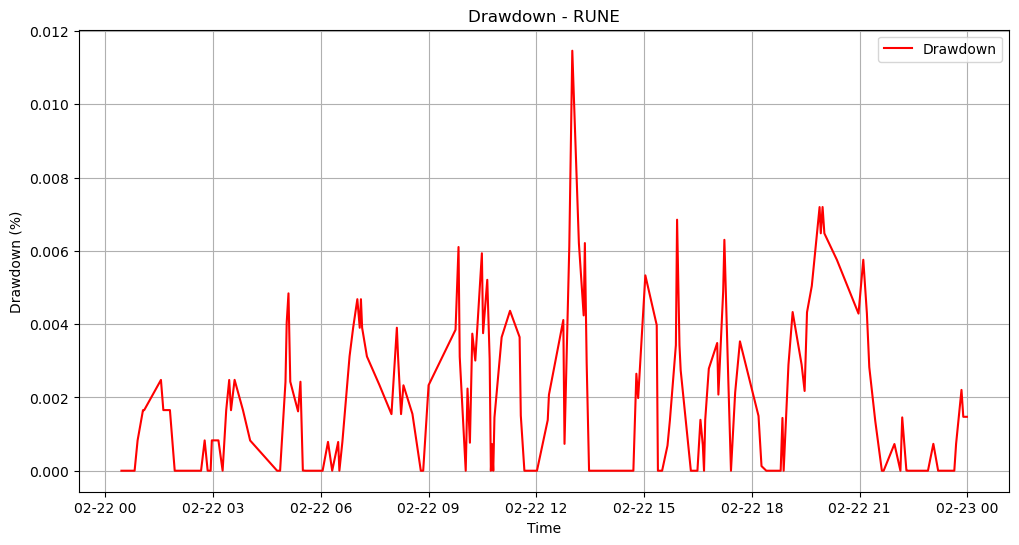

Instrument: SOL
Total Return (in %): 2.48
Max Drawdown (in %): 0.67
Sharpe Ratio: 2.03
Win/Loss Ratio: 0.97
Number of Trades: 317
-------------------------------------------------


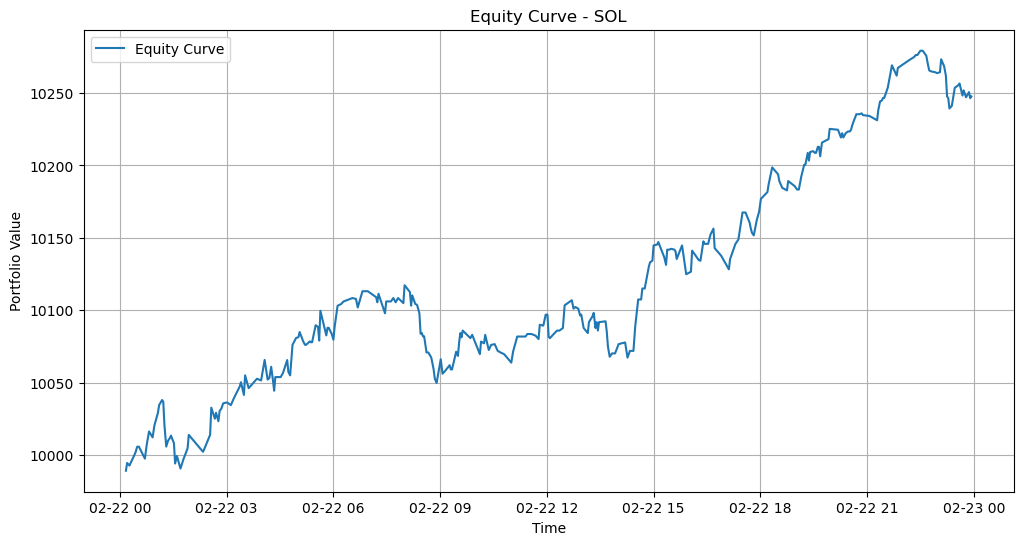

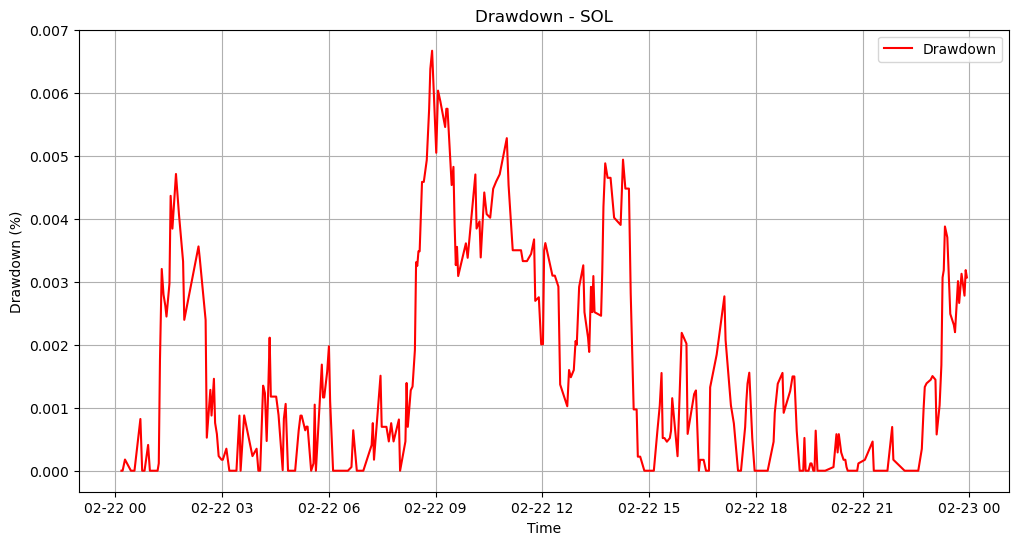

Instrument: PENDLE
Total Return (in %): 3.69
Max Drawdown (in %): 0.97
Sharpe Ratio: 2.80
Win/Loss Ratio: 1.01
Number of Trades: 147
-------------------------------------------------


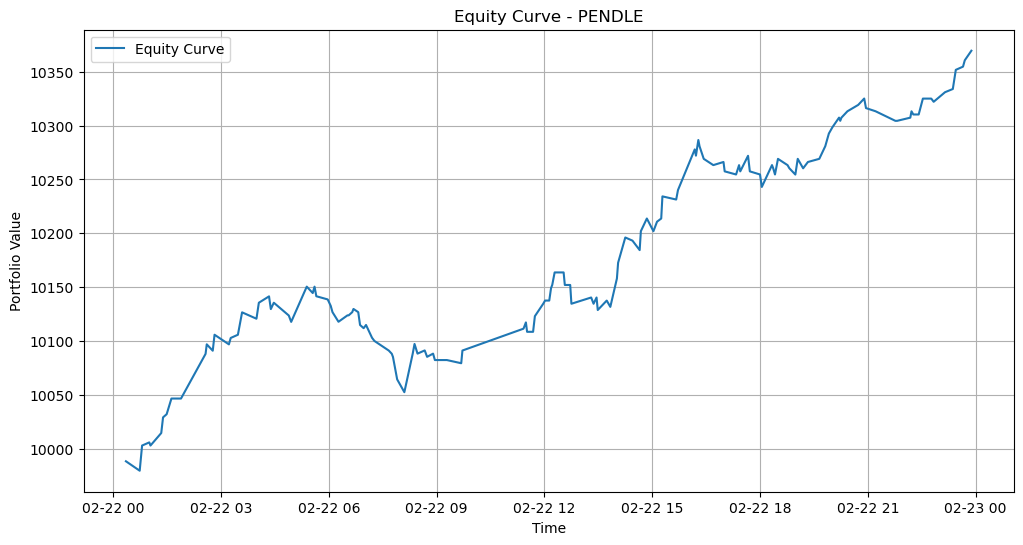

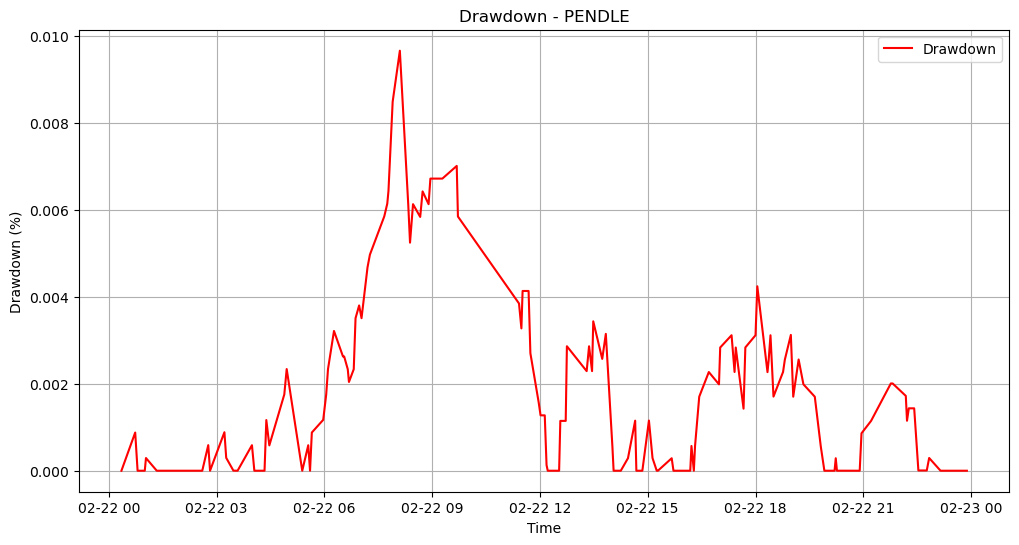

Instrument: BTC
Total Return (in %): 1.44
Max Drawdown (in %): 0.17
Sharpe Ratio: 3.30
Win/Loss Ratio: 0.92
Number of Trades: 288
-------------------------------------------------


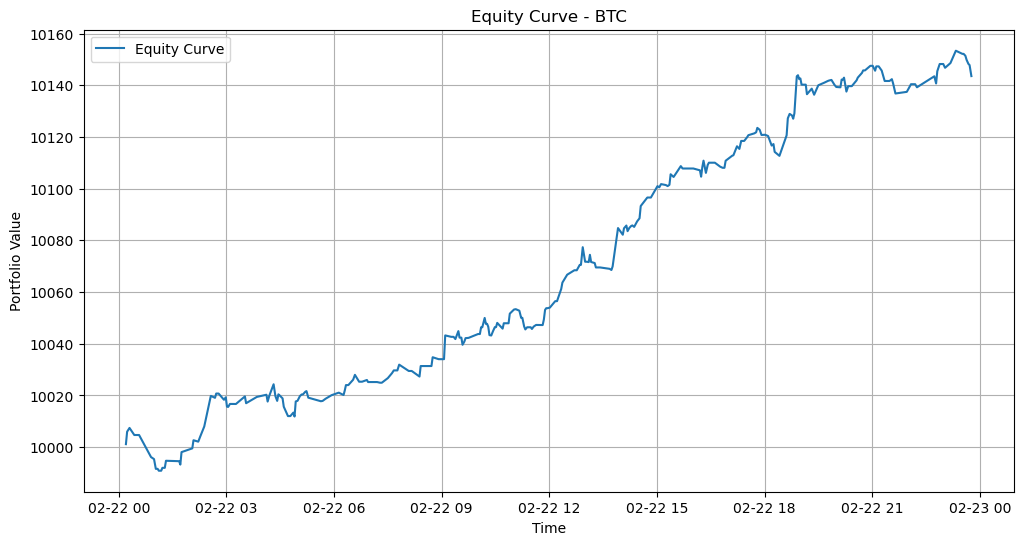

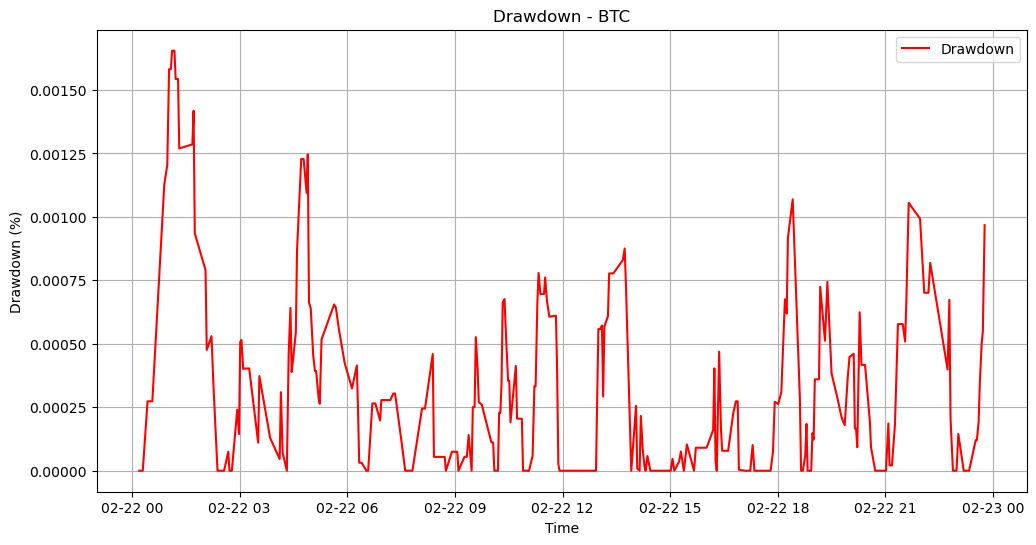

Instrument: ETH
Total Return (in %): 0.91
Max Drawdown (in %): 0.11
Sharpe Ratio: 3.61
Win/Loss Ratio: 3.00
Number of Trades: 20
-------------------------------------------------


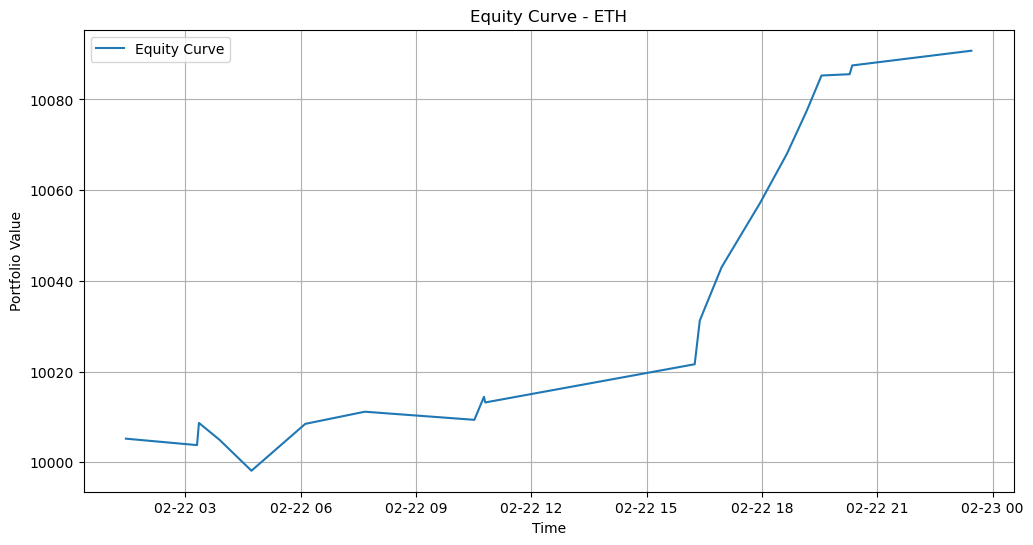

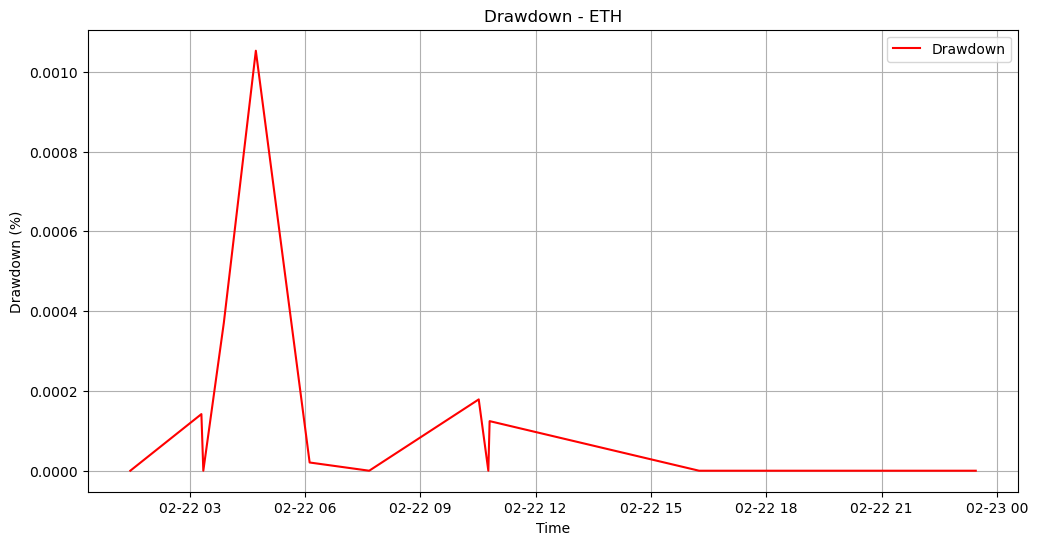

Instrument: USDC
Total Return (in %): 0.02
Max Drawdown (in %): 0.00
Sharpe Ratio: 1.60
Win/Loss Ratio: 0.29
Number of Trades: 9
-------------------------------------------------


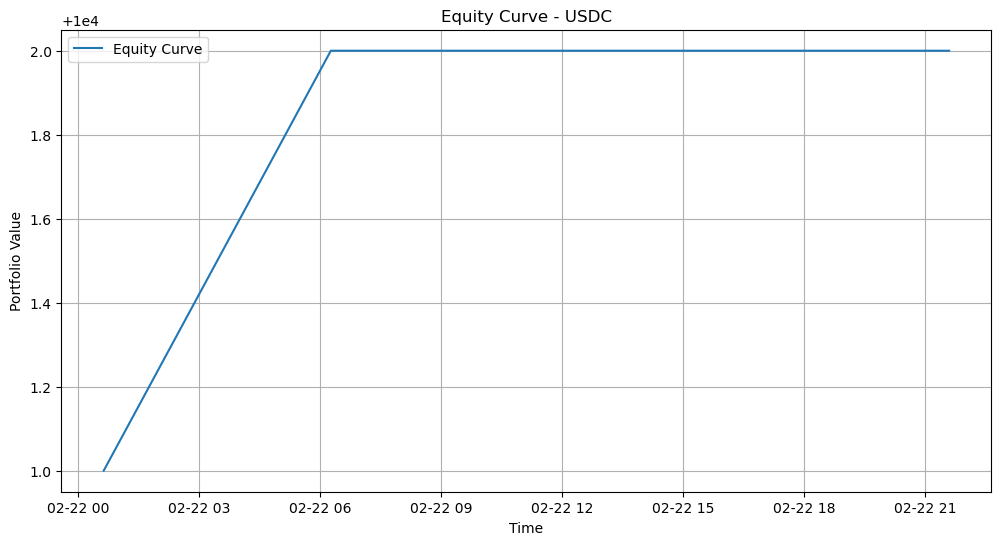

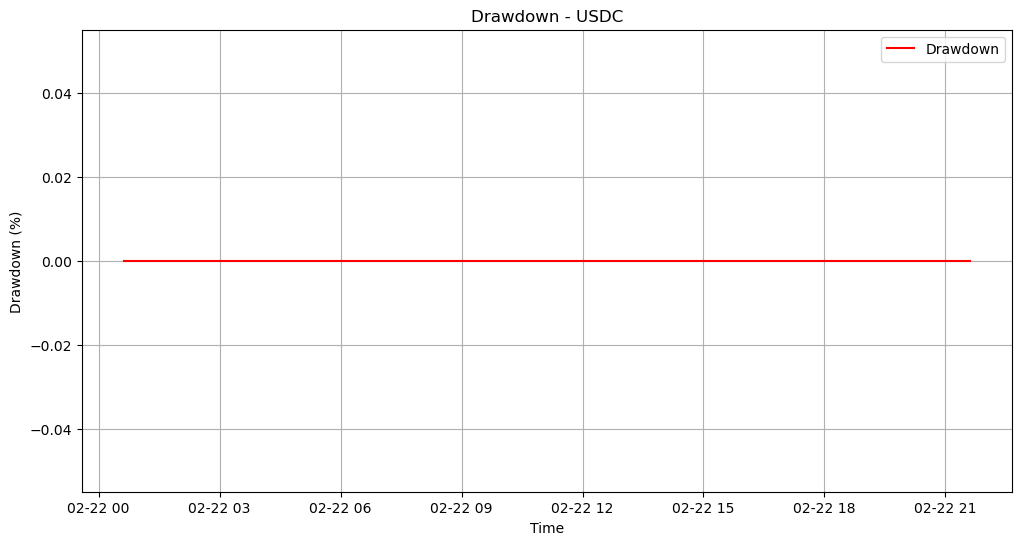

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def backtest(trades, initial_capital=10000):
    """
    Compute performance metrics based on a list of trades.
    
    Parameters:
      trades         : List of trades in the form
                       (entry_time, exit_time, entry_price, exit_price, direction)
      initial_capital: Starting portfolio value.
      
    Returns:
      metrics      : Dictionary containing total return, max drawdown, Sharpe ratio,
                     win/loss ratio, and number of trades.
      equity_curve : pandas Series of the portfolio value over time (at trade exit times).
    """
    # Calculate trade returns based on trade direction.
    trade_returns = []
    for (_, _, entry_price, exit_price, direction) in trades:
        if direction == 1:  # long
            r = (exit_price - entry_price) / entry_price
        elif direction == -1:  # short
            r = (entry_price - exit_price) / entry_price
        else:
            r = 0
        trade_returns.append(r)
        
    total_return = np.prod([1 + r for r in trade_returns]) - 1

    wins = [r for r in trade_returns if r > 0]
    losses = [r for r in trade_returns if r <= 0]
    win_loss_ratio = len(wins) / len(losses) if losses else np.nan

    equity = [initial_capital]
    equity_times = []
    for (_, exit_time, _, _, _), r in zip(trades, trade_returns):
        equity.append(equity[-1] * (1 + r))
        equity_times.append(exit_time)
    equity_curve = pd.Series(equity[1:], index=equity_times)

    rolling_max = equity_curve.cummax()
    # set precision to 10 decimal places to avoid division by zero
    rolling_max = rolling_max.round(10)
    drawdown = (rolling_max - equity_curve) / rolling_max
    max_drawdown = drawdown.max()

    if len(trade_returns) > 1:
        sharpe_ratio = (np.mean(trade_returns) / np.std(trade_returns)) * np.sqrt(len(trade_returns))
    else:
        sharpe_ratio = np.nan

    metrics = {
        'total_return': total_return,
        'max_drawdown': max_drawdown,
        'sharpe_ratio': sharpe_ratio,
        'win_loss_ratio': win_loss_ratio,
        'num_trades': len(trade_returns)
    }
    
    return metrics, equity_curve


def strategy_generator(df, short_window, long_window, threshold_multiplier, 
                       stop_loss_multiplier, take_profit_multiplier, trailing_stop_pct,
                       momentum_window=10, rsi_threshold_long=50, rsi_threshold_short=50,
                       use_volume_filter=True, volume_multiplier=1.0):
    """
    Generate trade signals and simulate trades using an EMA crossover strategy
    with adaptive parameters, an RSI momentum filter, and a volume filter.
    
    Parameters:
      df                  : pandas DataFrame with a 'mid_price' column and DateTime index.
      short_window        : span for the short exponential moving average.
      long_window         : span for the long exponential moving average.
      threshold_multiplier: multiplier to compute a dynamic threshold based on volatility.
      stop_loss_multiplier: multiplier to set stop loss dynamically using ATR.
      take_profit_multiplier: multiplier to set take profit dynamically using ATR.
      trailing_stop_pct   : trailing stop percentage (applied on favorable price move).
      momentum_window     : period over which to compute RSI and ATR.
      rsi_threshold_long  : minimum RSI required for a long signal.
      rsi_threshold_short : maximum RSI required for a short signal.
      use_volume_filter   : if True, only generate a signal when current avg volume
                            exceeds the rolling average (multiplied by volume_multiplier).
      volume_multiplier   : multiplier for the volume filter.
      
    Returns:
      trades : List of trades. Each trade is a tuple:
               (entry_time, exit_time, entry_price, exit_price, direction)
               where direction is 1 for long and -1 for short.
      df     : The DataFrame updated with EMA, dynamic threshold, ATR, RSI, volume info, signals, and positions.
    """
    # 1) Calculate exponential moving averages.
    df['EMA_short'] = df['mid_price'].ewm(span=short_window, adjust=False).mean()
    df['EMA_long']  = df['mid_price'].ewm(span=long_window, adjust=False).mean()
    
    # 2) Compute volatility (rolling std dev) and dynamic threshold.
    df['volatility'] = df['mid_price'].rolling(window=long_window).std()
    df['dynamic_threshold'] = threshold_multiplier * (df['volatility'] / df['mid_price'])
    
    # 3) Compute RSI as a momentum indicator.
    delta = df['mid_price'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=momentum_window, min_periods=momentum_window).mean()
    avg_loss = loss.rolling(window=momentum_window, min_periods=momentum_window).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # 4) Compute ATR (using absolute price change) as an approximate measure.
    df['tr'] = df['mid_price'].diff().abs()
    df['ATR'] = df['tr'].rolling(window=momentum_window, min_periods=momentum_window).mean()
    
    # 5) Compute a volume moving average if using volume filter.
    if use_volume_filter:
        df['vol_MA'] = df['avg_volume'].rolling(window=momentum_window, min_periods=momentum_window).mean()
    
    # 6) Generate signals:
    #    Long signal if: EMA_short > EMA_long*(1+dynamic_threshold) AND RSI > rsi_threshold_long
    #    and (if volume filtering) current avg_volume >= volume_multiplier * vol_MA.
    #    Short signal if: EMA_short < EMA_long*(1-dynamic_threshold) AND RSI < rsi_threshold_short
    #    and (if volume filtering) current avg_volume >= volume_multiplier * vol_MA.
    df['signal'] = 0
    subset_index = df.index[long_window:]  # valid where EMAs, dynamic_threshold, ATR, RSI (and volume MA) are available
    
    long_condition = (df.loc[subset_index, 'EMA_short'] > df.loc[subset_index, 'EMA_long'] * (1 + df.loc[subset_index, 'dynamic_threshold'])) & \
                     (df.loc[subset_index, 'RSI'] > rsi_threshold_long)
    short_condition = (df.loc[subset_index, 'EMA_short'] < df.loc[subset_index, 'EMA_long'] * (1 - df.loc[subset_index, 'dynamic_threshold'])) & \
                      (df.loc[subset_index, 'RSI'] < rsi_threshold_short)
    if use_volume_filter:
        long_condition = long_condition & (df.loc[subset_index, 'avg_volume'] >= volume_multiplier * df.loc[subset_index, 'vol_MA'])
        short_condition = short_condition & (df.loc[subset_index, 'avg_volume'] >= volume_multiplier * df.loc[subset_index, 'vol_MA'])
    
    df.loc[subset_index, 'signal'] = np.where(long_condition, 1, np.where(short_condition, -1, 0))
    
    # 7) Calculate changes in signal.
    df['positions'] = df['signal'].diff().fillna(0)
    
    # ----------------------
    # Trade Simulation Loop
    # ----------------------
    trades = []
    in_trade = False
    entry_price = None
    entry_time = None
    trade_direction = None  # 1 for long, -1 for short
    extreme_price = None    # Best favorable price since entry
    entry_ATR = None        # ATR at entry, used for dynamic stops/targets
    
    for index, row in df.iterrows():
        if not in_trade:
            if row['positions'] != 0:
                in_trade = True
                trade_direction = row['positions']  # 1 for long, -1 for short.
                entry_price = row['mid_price']
                entry_time = index
                extreme_price = entry_price
                entry_ATR = row['ATR']
        else:
            # Update extreme price for trailing stop.
            if trade_direction == 1 and row['mid_price'] > extreme_price:
                extreme_price = row['mid_price']
            elif trade_direction == -1 and row['mid_price'] < extreme_price:
                extreme_price = row['mid_price']
            
            # Dynamic stops and targets based on ATR.
            if entry_price is not None and entry_ATR is not None:
                dynamic_stop_loss = stop_loss_multiplier * (entry_ATR / entry_price)
                dynamic_take_profit = take_profit_multiplier * (entry_ATR / entry_price)
            else:
                dynamic_stop_loss = stop_loss_multiplier
                dynamic_take_profit = take_profit_multiplier
            
            exit_trade = False
            if trade_direction == 1:
                # Long trade exit conditions.
                if row['mid_price'] < extreme_price * (1 - trailing_stop_pct):  # trailing stop
                    exit_trade = True
                elif row['mid_price'] >= entry_price * (1 + dynamic_take_profit):  # take profit
                    exit_trade = True
                elif row['mid_price'] < entry_price * (1 - dynamic_stop_loss):  # stop loss
                    exit_trade = True
                elif row['positions'] < 0:  # signal reversal
                    exit_trade = True
            else:
                # Short trade exit conditions.
                if row['mid_price'] > extreme_price * (1 + trailing_stop_pct):  # trailing stop
                    exit_trade = True
                elif row['mid_price'] <= entry_price * (1 - dynamic_take_profit):  # take profit
                    exit_trade = True
                elif row['mid_price'] > entry_price * (1 + dynamic_stop_loss):  # stop loss
                    exit_trade = True
                elif row['positions'] > 0:  # signal reversal
                    exit_trade = True
            
            if exit_trade:
                exit_price = row['mid_price']
                trades.append((entry_time, index, entry_price, exit_price, trade_direction))
                in_trade = False
    
    if in_trade:
        exit_price = df.iloc[-1]['mid_price']
        trades.append((entry_time, df.index[-1], entry_price, exit_price, trade_direction))
    
    return trades, df




# -----------------------------------------------------------------------------------
# Example usage across instruments (assuming df_all is loaded with an 'instrument' column)
df_params = pd.read_csv('best_results.csv', index_col=0).T
df_params.index.name = 'instrument'
for instrument in df_all['instrument'].unique():
    df_inst = df_all[df_all['instrument'] == instrument]
    df_resampled = df_inst.resample('1min').agg({'mid_price': 'last', 'avg_volume': 'last'}).dropna()
    # df_resampled = df_inst.resample('10S').agg({'mid_price': 'last', 'avg_volume': 'last'}).dropna()
    df_resampled = df_resampled.iloc[2:]  # discard initial rows if desired

    params = df_params.loc[instrument]
    short_window = int(params['best_params_short_window'])
    long_window = int(params['best_params_long_window'])
    threshold_multiplier = float(params['best_params_threshold_multiplier'])
    stop_loss_multiplier = float(params['best_params_stop_loss_multiplier'])
    take_profit_multiplier = float(params['best_params_take_profit_multiplier'])
    trailing_stop_pct = float(params['best_params_trailing_stop_pct'])
    momentum_window = int(params['best_params_momentum_window'])
    rsi_threshold_long = int(params['best_params_rsi_threshold_long'])
    rsi_threshold_short = int(params['best_params_rsi_threshold_short'])
    volume_multiplier = float(params['best_params_volume_multiplier'])
    use_volume_filter = True

    # # Set adaptive strategy parameters:
    # short_window = 20
    # long_window = 100
    # threshold_multiplier = 0         # Using no extra multiplier for dynamic threshold
    # stop_loss_multiplier = 0.005       # Multiplier for ATR-based stop loss
    # take_profit_multiplier = 0.001     # Multiplier for ATR-based take profit
    # trailing_stop_pct = 0.005          # 0.5% trailing stop
    # momentum_window = 40               # Used for ATR, RSI, and volume MA
    # rsi_threshold_long = 55            # RSI must be above 55 for a long signal
    # rsi_threshold_short = 45           # RSI must be below 45 for a short signal
    # use_volume_filter = True           # Enable volume filter
    # volume_multiplier = 0.6           # Current avg volume must be at least equal to rolling avg volume
    
    trades, df_strategy = strategy_generator(
        df_resampled.copy(),
        short_window,
        long_window,
        threshold_multiplier,
        stop_loss_multiplier,
        take_profit_multiplier,
        trailing_stop_pct,
        momentum_window,
        rsi_threshold_long,
        rsi_threshold_short,
        use_volume_filter,
        volume_multiplier
    )
    metrics, equity_curve = backtest(trades)
    print(f"Instrument: {instrument}")
    print(f"Total Return (in %): {metrics['total_return']*100:.2f}")
    print(f"Max Drawdown (in %): {metrics['max_drawdown']*100:.2f}")
    print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
    print(f"Win/Loss Ratio: {metrics['win_loss_ratio']:.2f}")
    print(f"Number of Trades: {metrics['num_trades']}")
    print("-------------------------------------------------")
    
    # # Save or plot results:
    # plt.figure(figsize=(12, 6))
    # plt.plot(df_strategy.index, df_strategy['mid_price'], label='Mid Price')
    # plt.title(f'Price of instrument {instrument}')
    # plt.xlabel('Time')
    # plt.ylabel('Price')
    # plt.legend()
    # plt.savefig("price_" + instrument + ".png")
    
    # plt.figure(figsize=(12, 6))
    # plt.plot(df_strategy.index, df_strategy['mid_price'], label='Mid Price')
    # for trade in trades:
    #     entry_time, exit_time, entry_price, exit_price, direction = trade
    #     color = 'green' if direction == 1 else 'red'
    #     plt.plot([entry_time, exit_time], [entry_price, exit_price], color=color, marker='o')
    # plt.title(f'Trades of instrument {instrument}')
    # plt.xlabel('Time')
    # plt.ylabel('Price')
    # plt.legend()
    # plt.savefig("trades_" + instrument + ".png")
    
    # plt.figure(figsize=(12, 6))
    # plt.plot(df_strategy.index, df_strategy['mid_price'], label='Mid Price')
    # plt.plot(df_strategy[df_strategy['positions'] > 0].index, df_strategy[df_strategy['positions'] > 0]['mid_price'], 'o', markersize=5, color='green', label='Long Signal')
    # plt.plot(df_strategy[df_strategy['positions'] < 0].index, df_strategy[df_strategy['positions'] < 0]['mid_price'], 'o', markersize=5, color='red', label='Short Signal')
    # plt.title(f'Position Signals for instrument {instrument}')
    # plt.xlabel('Time')
    # plt.ylabel('Price')
    # plt.legend()
    # plt.savefig("positions_" + instrument + ".png")
    # Plot and save the equity curve.
    plt.figure(figsize=(12, 6))
    plt.plot(equity_curve.index, equity_curve, label='Equity Curve')
    plt.title(f'Equity Curve - {instrument}')
    plt.xlabel('Time')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid(True)
    plt.savefig("equity_curve_" + instrument + ".png")
    plt.show()
    
    # Compute drawdown: (rolling max - equity) / rolling max.
    rolling_max = equity_curve.cummax()
    drawdown = (rolling_max - equity_curve) / rolling_max
    
    # Plot and save the drawdown curve.
    plt.figure(figsize=(12, 6))
    plt.plot(drawdown.index, drawdown, label='Drawdown', color='red')
    plt.title(f'Drawdown - {instrument}')
    plt.xlabel('Time')
    plt.ylabel('Drawdown (%)')
    plt.legend()
    plt.grid(True)
    plt.savefig("drawdown_" + instrument + ".png")
    plt.show()

# Grid Search for best params

In [ ]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# STEP 0: Define your functions
# (Assuming backtest() and strategy_generator() are defined as above)
# ---------------------------

# (Include your definitions of backtest() and strategy_generator() here.)
# For brevity, we assume they are already defined as in your previous code.

# ---------------------------
# STEP 1: Define parameter grids for Group A and Group B
# ---------------------------

param_grid_A = {
    'short_window': [2, 4, 10],
    'long_window': [8, 16, 32],
    'threshold_multiplier': [0, 0.005],
    'stop_loss_multiplier': [0.005, 0.001, 0.01],
    'take_profit_multiplier': [0.01, 0.001, 0.005],
    'trailing_stop_pct': [0.005, 0.01, 0.001],
    'momentum_window': [5, 10, 15, 20]
}

param_grid_B = {
    'rsi_threshold_long': [50, 55, 60, 65, 70],
    'rsi_threshold_short': [50, 45, 40, 35, 30],
    'volume_multiplier': [0.2, 0.4, 0.6, 0.8, 1]
}

# For the first step, hold Group B constant (set to default values).
default_B = {
    'rsi_threshold_long': 55,
    'rsi_threshold_short': 45,
    'volume_multiplier': 0.6
}

keys_A = list(param_grid_A.keys())
combinations_A = list(itertools.product(*[param_grid_A[k] for k in keys_A]))

keys_B = list(param_grid_B.keys())
combinations_B = list(itertools.product(*[param_grid_B[k] for k in keys_B]))

# ---------------------------
# STEP 2: Grid search for each instrument: First over Group A, then Group B.
# ---------------------------

# Dictionary to store best overall results for each instrument.
best_results = {}

# Loop over each instrument in your combined DataFrame (df_all)
for instrument in df_all['instrument'].unique():
    print("Processing instrument:", instrument)
    # Filter data and resample to 1-minute bars (ensure 'mid_price' and 'avg_volume' exist)
    df_inst = df_all[df_all['instrument'] == instrument]
    # df_resampled = df_inst.resample('1min').agg({'mid_price': 'last', 'avg_volume': 'last'}).dropna()
    df_resampled = df_inst.resample('1min').agg({'mid_price': 'last', 'avg_volume': 'last'}).dropna()
    df_resampled = df_resampled.iloc[2:]  # Discard initial rows if desired

    # --- STEP 2A: Optimize Group A parameters (price/volatility parameters) ---
    best_sharpe_A = -np.inf
    best_params_A = None
    best_metrics_A = None

    for comb_A in combinations_A:
        params_A = dict(zip(keys_A, comb_A))
        # Combine Group A with constant Group B defaults.
        params = {**params_A, **default_B}
        
        # Run strategy using these parameters.
        trades, df_strategy = strategy_generator(
            df_resampled.copy(),
            short_window=int(params['short_window']),
            long_window=int(params['long_window']),
            threshold_multiplier=params['threshold_multiplier'],
            stop_loss_multiplier=params['stop_loss_multiplier'],
            take_profit_multiplier=params['take_profit_multiplier'],
            trailing_stop_pct=params['trailing_stop_pct'],
            momentum_window=int(params['momentum_window']),
            rsi_threshold_long=params['rsi_threshold_long'],
            rsi_threshold_short=params['rsi_threshold_short'],
            use_volume_filter=True,
            volume_multiplier=params['volume_multiplier']
        )
        metrics, equity_curve = backtest(trades)
        
        if metrics['sharpe_ratio'] > best_sharpe_A:
            best_sharpe_A = metrics['sharpe_ratio']
            best_params_A = params_A
            best_metrics_A = metrics

    print(f"Best Group A for {instrument}: {best_params_A} with Sharpe {best_sharpe_A:.2f}")
    
    # --- STEP 2B: Optimize Group B parameters while holding Group A fixed ---
    best_sharpe_B = -np.inf
    best_params_B = None
    best_metrics_B = None

    # Combine best Group A parameters with each candidate from Group B.
    for comb_B in combinations_B:
        params_B = dict(zip(keys_B, comb_B))
        params = {**best_params_A, **params_B}  # Combine best A with candidate B
        
        trades, df_strategy = strategy_generator(
            df_resampled.copy(),
            short_window=int(params['short_window']),
            long_window=int(params['long_window']),
            threshold_multiplier=params['threshold_multiplier'],
            stop_loss_multiplier=params['stop_loss_multiplier'],
            take_profit_multiplier=params['take_profit_multiplier'],
            trailing_stop_pct=params['trailing_stop_pct'],
            momentum_window=int(params['momentum_window']),
            rsi_threshold_long=params['rsi_threshold_long'],
            rsi_threshold_short=params['rsi_threshold_short'],
            use_volume_filter=True,
            volume_multiplier=params['volume_multiplier']
        )
        metrics, equity_curve = backtest(trades)
        
        if metrics['sharpe_ratio'] > best_sharpe_B:
            best_sharpe_B = metrics['sharpe_ratio']
            best_params_B = params_B
            best_metrics_B = metrics

    # Combine best parameters from both groups.
    best_overall_params = {**best_params_A, **best_params_B}
    best_results[instrument] = {
        'best_params': best_overall_params,
        'best_metrics': best_metrics_B
    }
    
    print(f"Instrument: {instrument}")
    print("Best Overall Parameters:")
    print(best_overall_params)
    print("Performance Metrics:")
    print(best_metrics_B)
    print("-------------------------------------------------")

results_df = pd.DataFrame({
    instrument: {
        **{'best_params_' + k: v for k, v in best_results[instrument]['best_params'].items()},
        **{'total_return': best_results[instrument]['best_metrics']['total_return'],
           'max_drawdown': best_results[instrument]['best_metrics']['max_drawdown'],
           'sharpe_ratio': best_results[instrument]['best_metrics']['sharpe_ratio'],
           'win_loss_ratio': best_results[instrument]['best_metrics']['win_loss_ratio'],
           'num_trades': best_results[instrument]['best_metrics']['num_trades']}
    }
    for instrument in best_results
})

print("Best Results for all instruments:")
print(results_df)
results_df.to_csv('best_results.csv')


Processing instrument: RUNE
Best Group A for RUNE: {'short_window': 10, 'long_window': 8, 'threshold_multiplier': 0, 'stop_loss_multiplier': 0.005, 'take_profit_multiplier': 0.01, 'trailing_stop_pct': 0.005, 'momentum_window': 15} with Sharpe 0.60


KeyboardInterrupt: 

# ML Experiments

## Regression

Overall Test MSE: 1714290.983641
ML Regression Strategy Performance Metrics:
{'total_return': inf, 'max_drawdown': 1.254517395823198e-16, 'sharpe_ratio': 80.08024546198104, 'win_loss_ratio': 901.3333333333334, 'num_trades': 27070}


/home/burouj/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/burouj/.local/lib/python3.8/site-packages/pandas/core/series.py:2393: RuntimeWarning: overflow encountered in multiply
  result = self._values.round(decimals)


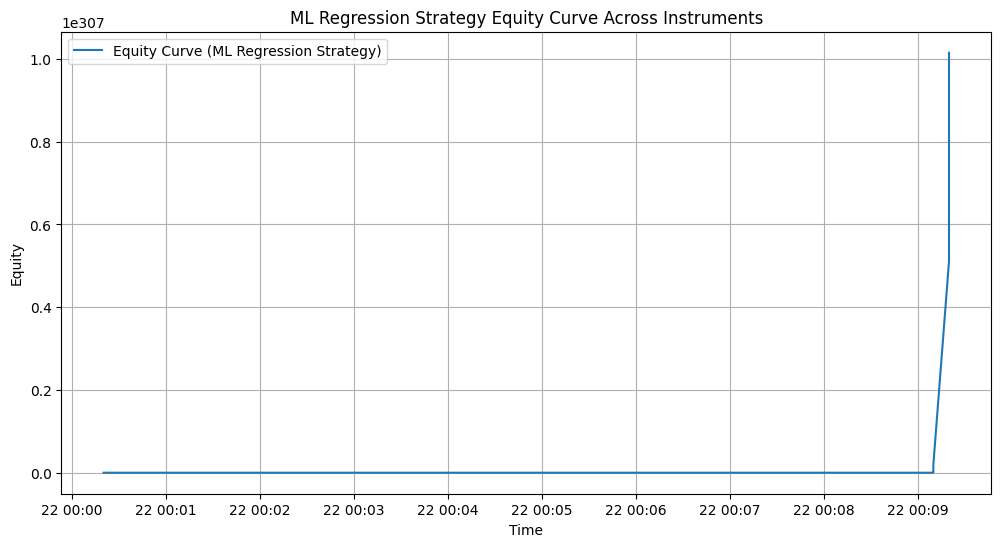

ML Regression Strategy Performance Metrics for ETH:
{'total_return': 0.04048642450874618, 'max_drawdown': 3.67124227425629e-15, 'sharpe_ratio': nan, 'win_loss_ratio': nan, 'num_trades': 1}


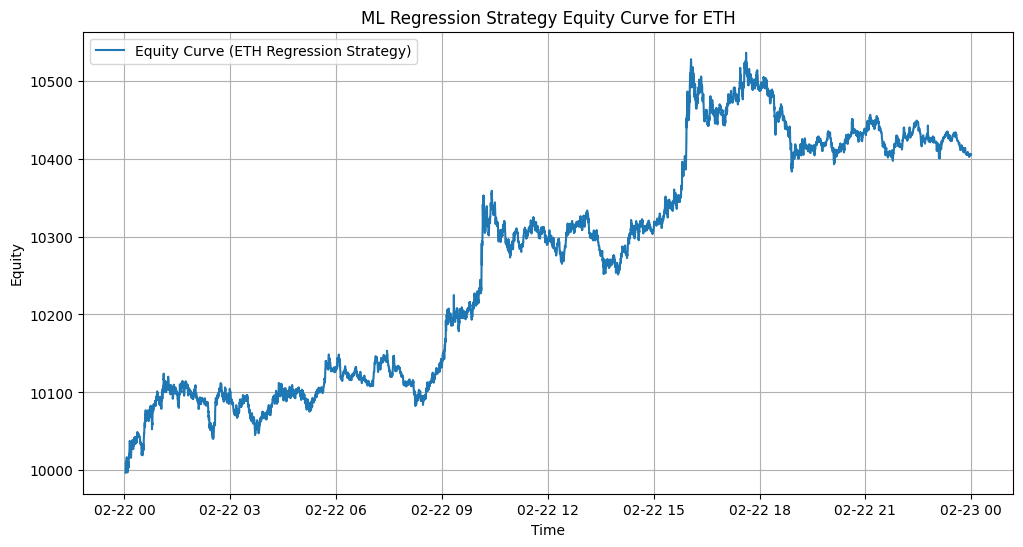

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def compute_technical_indicators(df, momentum_window=10):
    """
    Compute a set of technical indicators for the DataFrame.
    """
    df['EMA_short'] = df['mid_price'].ewm(span=5, adjust=False).mean()
    df['EMA_long'] = df['mid_price'].ewm(span=15, adjust=False).mean()
    
    delta = df['mid_price'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=momentum_window, min_periods=momentum_window).mean()
    avg_loss = loss.rolling(window=momentum_window, min_periods=momentum_window).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    df['TR'] = df['mid_price'].diff().abs()
    df['ATR'] = df['TR'].rolling(window=momentum_window, min_periods=momentum_window).mean()
    
    if 'avg_volume' in df.columns:
        df['vol_MA'] = df['avg_volume'].rolling(window=momentum_window, min_periods=momentum_window).mean()
    
    df.dropna(inplace=True)
    return df

def generate_features_labels_regression(df):
    """
    Compute features and a continuous target (next period's return).
    Also, add instrument as a categorical feature using a fixed list for one-hot encoding.
    """
    df = compute_technical_indicators(df, momentum_window=10)
    
    # Compute the target: next period's return (continuous)
    df['target_return'] = df['mid_price'].pct_change().shift(-1)
    df.dropna(inplace=True)
    
    feature_cols = ['mid_price', 'EMA_short', 'EMA_long', 'RSI', 'ATR']
    if 'avg_volume' in df.columns and 'vol_MA' in df.columns:
        feature_cols += ['avg_volume', 'vol_MA']
    
    # Fixed list of instruments for one-hot encoding.
    instruments = ['SOL', 'USDC', 'RUNE', 'PENDLE', 'ETH', 'BTC']
    df['instrument'] = pd.Categorical(df['instrument'], categories=instruments)
    instruments_dummies = pd.get_dummies(df['instrument'], prefix='inst')
    
    X = pd.concat([df[feature_cols], instruments_dummies], axis=1)
    y = df['target_return']
    
    return X, y, df

def train_ml_model_regression(X, y, groups, train_ratio=0.5):
    """
    For each instrument (group), split the data by time using the provided train_ratio,
    then combine training parts and testing parts across instruments, and train a regressor.
    """
    X_train_list = []
    y_train_list = []
    X_test_list = []
    y_test_list = []
    
    for inst in groups.unique():
        inst_idx = groups[groups == inst].index
        df_inst = X.loc[inst_idx].copy()
        df_inst.sort_index(inplace=True)
        n = len(df_inst)
        split_point = int(n * train_ratio)
        train_idx = df_inst.index[:split_point]
        test_idx = df_inst.index[split_point:]
        X_train_list.append(X.loc[train_idx])
        y_train_list.append(y.loc[train_idx])
        X_test_list.append(X.loc[test_idx])
        y_test_list.append(y.loc[test_idx])
    
    X_train = pd.concat(X_train_list)
    y_train = pd.concat(y_train_list)
    X_test = pd.concat(X_test_list)
    y_test = pd.concat(y_test_list)
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Overall Test MSE: {mse:.6f}")
    
    return model, X_train, X_test, y_train, y_test

def ml_strategy_regression(df, model, long_threshold=0.0001, short_threshold=-0.0001):
    """
    Use the trained regression model to generate trade signals.
    A simple strategy:
      - If predicted return > long_threshold, go long.
      - If predicted return < short_threshold, go short.
      - Otherwise, stay flat.
    Generates a list of trades based on signal transitions.
    """
    X, y, df_features = generate_features_labels_regression(df.copy())
    df_features['predicted_return'] = model.predict(X)
    
    # Generate positions based on thresholds.
    # 1 for long, -1 for short, 0 for flat.
    df_features['position'] = 0
    df_features.loc[df_features['predicted_return'] > long_threshold, 'position'] = 1
    df_features.loc[df_features['predicted_return'] < short_threshold, 'position'] = -1
    
    # Generate trades based on changes in position.
    trades = []
    current_position = 0
    entry_time = None
    entry_price = None
    for time, row in df_features.iterrows():
        new_position = row['position']
        # Enter a trade if current position is flat and new position is non-zero.
        if current_position == 0 and new_position != 0:
            current_position = new_position
            entry_time = time
            entry_price = row['mid_price']
        # Exit trade if position changes.
        elif current_position != 0 and new_position != current_position:
            exit_time = time
            exit_price = row['mid_price']
            trades.append((entry_time, exit_time, entry_price, exit_price, current_position))
            current_position = new_position
            # If new_position is not flat, re-enter at the same time.
            if current_position != 0:
                entry_time = time
                entry_price = row['mid_price']
    if current_position != 0:
        exit_time = df_features.index[-1]
        exit_price = df_features.iloc[-1]['mid_price']
        trades.append((entry_time, exit_time, entry_price, exit_price, current_position))
    
    # Compute strategy returns and equity curve.
    df_features['strategy_return'] = df_features['mid_price'].pct_change() * df_features['position'].shift(1)
    df_features['strategy_equity'] = (1 + df_features['strategy_return']).cumprod()
    initial_capital = 10000
    equity_curve = initial_capital * df_features['strategy_equity']
    
    return trades, equity_curve, df_features

# ---------------------------
# Combined Data and Model Training Across Instruments
# ---------------------------
# Assume df_all is the combined DataFrame with columns: 'mid_price', 'avg_volume', 'instrument', etc.
# Resample data if needed (here, to 10-second bars).
# We resample each instrument separately:
resampled_dfs = []
for inst in df_all['instrument'].unique():
    df_inst = df_all[df_all['instrument'] == inst].copy()
    # Resample the individual instrument's DataFrame to 10-second bars.
    df_inst_resampled = df_inst.resample('10S').agg({
        'mid_price': 'last',
        'avg_volume': 'last'
    }).dropna()
    # Re-add the instrument column (since it is lost during resampling).
    df_inst_resampled['instrument'] = inst
    resampled_dfs.append(df_inst_resampled)

# Combine the separately resampled DataFrames.
df_all_processed = pd.concat(resampled_dfs).sort_index()
# Generate features and labels for regression.
X, y, df_features = generate_features_labels_regression(df_all_processed)
groups = df_features['instrument']

# Train the regression model using a configurable train_ratio (default 0.5).
model_reg, X_train, X_test, y_train, y_test = train_ml_model_regression(X, y, groups, train_ratio=0.5)

# ---------------------------
# ML Strategy Based on Regression Predictions Across Instruments
# ---------------------------
# trades_reg, equity_curve_reg, df_ml_reg = ml_strategy_regression(df_all_processed, model_reg,
#                                                                   long_threshold=0.0001, short_threshold=-0.0001)
# metrics_reg, _ = backtest(trades_reg, initial_capital=10000)
# print("ML Regression Strategy Performance Metrics:")
# print(metrics_reg)

# plt.figure(figsize=(12, 6))
# plt.plot(equity_curve_reg.index, equity_curve_reg, label='Equity Curve (ML Regression Strategy)')
# plt.title('ML Regression Strategy Equity Curve Across Instruments')
# plt.xlabel('Time')
# plt.ylabel('Equity')
# plt.legend()
# plt.grid(True)
# plt.show()

# ---------------------------
# Now test the trained regression model on a specific instrument, e.g., ETH.
# ---------------------------
df_ETH = df_all_processed[df_all_processed['instrument'] == 'ETH']
trades_eth, equity_curve_eth, df_ml_eth = ml_strategy_regression(df_ETH.copy(), model_reg,
                                                                  long_threshold=0.0001, short_threshold=-0.0001)
metrics_eth, _ = backtest(trades_eth, initial_capital=10000)
print("ML Regression Strategy Performance Metrics for ETH:")
print(metrics_eth)

# plt.figure(figsize=(12, 6))
# plt.plot(equity_curve_eth.index, equity_curve_eth, label='Equity Curve (ETH Regression Strategy)')
# plt.title('ML Regression Strategy Equity Curve for ETH')
# plt.xlabel('Time')
# plt.ylabel('Equity')
# plt.legend()
# plt.grid(True)
# plt.show()


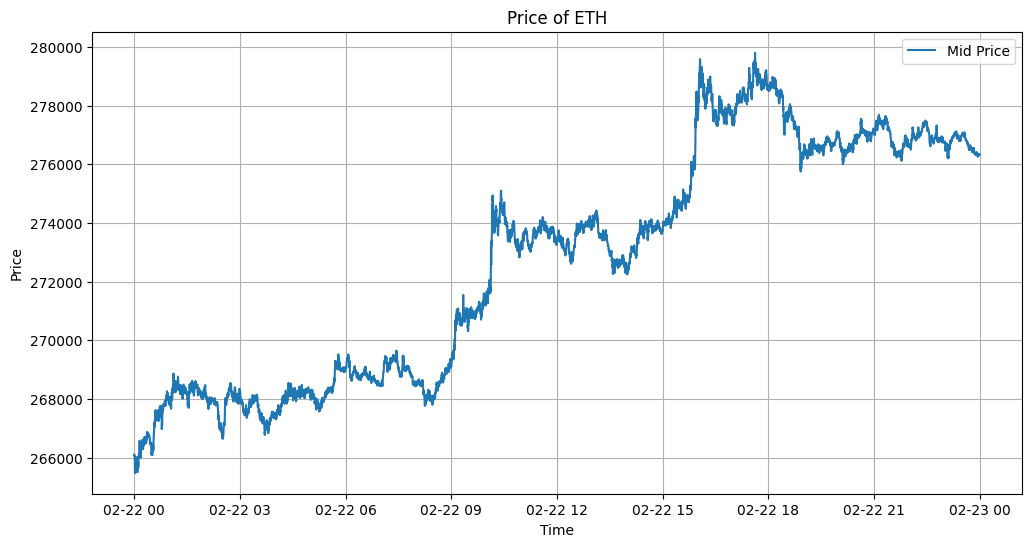

Distribution of labels in the dataset:
timestamp
2025-02-22 00:00:00    -0.936515
2025-02-22 00:00:10    -0.936536
2025-02-22 00:00:20    -0.987276
2025-02-22 00:00:30    -0.987279
2025-02-22 00:00:40    35.151619
                         ...    
2025-02-22 23:59:10    -0.995084
2025-02-22 23:59:20    -0.963812
2025-02-22 23:59:30    -0.937730
2025-02-22 23:59:40    -0.987346
2025-02-22 23:59:50    -0.963812
Name: target_return, Length: 8640, dtype: float64
Predicted returns:
timestamp
2025-02-22 00:01:40    32.812001
2025-02-22 00:01:50    32.812001
2025-02-22 00:02:00    32.450618
2025-02-22 00:02:10    32.811613
2025-02-22 00:02:20    32.450864
                         ...    
2025-02-22 23:59:00    22.887093
2025-02-22 23:59:10    22.887093
2025-02-22 23:59:20    22.887093
2025-02-22 23:59:30    30.745169
2025-02-22 23:59:40    30.001540
Name: predicted_return, Length: 8621, dtype: float64
ML Regression Strategy Performance Metrics for ETH:
{'total_return': 0.04048642450874618, 'ma

In [49]:
# ---------------------------
# Now test the trained regression model on a specific instrument, e.g., ETH.
# ---------------------------
df_ETH = df_all_processed[df_all_processed['instrument'] == 'ETH']
# plot the price of ETH
plt.figure(figsize=(12, 6))
plt.plot(df_ETH.index, df_ETH['mid_price'], label='Mid Price')
plt.title('Price of ETH')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
# print the distribution of labels in the dataset
print("Distribution of labels in the dataset:")
print(df_ETH['target_return'])
# save in a file
df_ETH.to_csv('df_ETH.csv')

trades_eth, equity_curve_eth, df_ml_eth = ml_strategy_regression(df_ETH.copy(), model_reg,
                                                                  long_threshold=0.0001, short_threshold=-0.0001)
# print the predicted returns
print("Predicted returns:")
print(df_ml_eth['predicted_return'])
# save ina file 
df_ml_eth.to_csv('df_ml_eth.csv')
metrics_eth, _ = backtest(trades_eth, initial_capital=10000)
print("ML Regression Strategy Performance Metrics for ETH:")
print(metrics_eth)


## LSTM

In [4]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# ---------------------------
# Step 1: Enhanced Feature Engineering
# ---------------------------
def compute_technical_indicators(df, momentum_window=10):
    """
    Compute several technical indicators.
    """
    df['EMA_short'] = df['mid_price'].ewm(span=5, adjust=False).mean()
    df['EMA_long'] = df['mid_price'].ewm(span=15, adjust=False).mean()
    df['MACD'] = df['EMA_short'] - df['EMA_long']
    df['Bollinger_upper'] = df['mid_price'].rolling(window=momentum_window).mean() + 2 * df['mid_price'].rolling(window=momentum_window).std()
    df['Bollinger_lower'] = df['mid_price'].rolling(window=momentum_window).mean() - 2 * df['mid_price'].rolling(window=momentum_window).std()
    
    delta = df['mid_price'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=momentum_window, min_periods=momentum_window).mean()
    avg_loss = loss.rolling(window=momentum_window, min_periods=momentum_window).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    df['TR'] = df['mid_price'].diff().abs()
    df['ATR'] = df['TR'].rolling(window=momentum_window, min_periods=momentum_window).mean()
    
    if 'avg_volume' in df.columns:
        df['vol_MA'] = df['avg_volume'].rolling(window=momentum_window, min_periods=momentum_window).mean()
    
    df.dropna(inplace=True)
    return df

# ---------------------------
# Step 2: Generate ML Dataset with Per-Instrument Scaling
# ---------------------------
def generate_ml_dataset_per_instrument(df, lookback=20):
    """
    Generate a sequence dataset for LSTM using per-instrument scaling.
    
    For each instrument, compute technical indicators, then scale features and target separately,
    and then reassemble the data. Instrument is also one-hot encoded using a fixed list.
    
    Returns:
      X_seq: 3D numpy array of shape (num_sequences, lookback, num_features)
      y_seq: 2D numpy array of targets (num_sequences, 1)
      scaler_X_dict: Dictionary mapping instrument -> scaler for features.
      scaler_y_dict: Dictionary mapping instrument -> scaler for target.
      df_scaled: Combined scaled DataFrame (for reference).
    """
    # Compute technical indicators and target.
    df = compute_technical_indicators(df, momentum_window=10)
    df['target'] = df['mid_price'].pct_change().shift(-1)
    df.dropna(inplace=True)
    
    # Fixed list of instruments for one-hot encoding.
    instruments = ['SOL', 'USDC', 'RUNE', 'PENDLE', 'ETH', 'BTC']
    df['instrument'] = pd.Categorical(df['instrument'], categories=instruments)
    
    # Process each instrument separately.
    scaled_dfs = []
    scaler_X_dict = {}
    scaler_y_dict = {}
    
    # Define base feature columns.
    base_features = ['mid_price', 'EMA_short', 'EMA_long', 'MACD', 'Bollinger_upper', 'Bollinger_lower', 
                     'RSI', 'ATR']
    if 'avg_volume' in df.columns and 'vol_MA' in df.columns:
        base_features += ['avg_volume', 'vol_MA']
    
    for inst in instruments:
        df_inst = df[df['instrument'] == inst].copy()
        if df_inst.empty:
            continue
        # Create dummy variables for this instrument.
        dummies_inst = pd.get_dummies(df_inst['instrument'], prefix='inst')
        
        # Extract features and target.
        X_inst = df_inst[base_features].values
        y_inst = df_inst['target'].values.reshape(-1, 1)
        
        # Scale features and target per instrument.
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_scaled_inst = scaler_X.fit_transform(X_inst)
        y_scaled_inst = scaler_y.fit_transform(y_inst)
        
        # Create a DataFrame for the scaled features.
        df_scaled_inst = pd.DataFrame(X_scaled_inst, columns=base_features, index=df_inst.index)
        # Append fixed dummy columns for instrument.
        df_scaled_inst = pd.concat([df_scaled_inst, dummies_inst], axis=1)
        # Add the instrument identifier.
        df_scaled_inst['instrument'] = inst
        # Add the scaled target.
        df_scaled_inst['target'] = y_scaled_inst.flatten()
        scaled_dfs.append(df_scaled_inst)
        
        # Save the scalers.
        scaler_X_dict[inst] = scaler_X
        scaler_y_dict[inst] = scaler_y
    
    # Combine all instrument data.
    df_scaled = pd.concat(scaled_dfs).sort_index()
    
    # For creating sequences, drop non-numeric columns ('target' will be used as y, but instrument is non-numeric)
    X_all = df_scaled.drop(columns=['target', 'instrument']).values
    y_all = df_scaled['target'].values.reshape(-1, 1)
    
    sequences = []
    targets = []
    for i in range(lookback, len(X_all)):
        sequences.append(X_all[i-lookback:i])
        targets.append(y_all[i])
    
    # Explicitly convert to np.float32.
    X_seq = np.array(sequences, dtype=np.float32)
    y_seq = np.array(targets, dtype=np.float32)
    
    return X_seq, y_seq, scaler_X_dict, scaler_y_dict, df_scaled




# ---------------------------
# Step 3: Build LSTM Model
# ---------------------------
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

# ---------------------------
# Step 4: Train and Evaluate LSTM Model
# ---------------------------
def train_lstm_model(X_seq, y_seq, train_ratio=0.5, epochs=50, batch_size=32):
    n_train = int(len(X_seq) * train_ratio)
    X_train, X_test = X_seq[:n_train], X_seq[n_train:]
    y_train, y_test = y_seq[:n_train], y_seq[n_train:]
    
    model = build_lstm_model(input_shape=(X_seq.shape[1], X_seq.shape[2]))
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_test, y_test), 
              epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=1)
    
    y_pred = model.predict(X_test)
    mse = np.mean((y_test - y_pred)**2)
    print(f"Test MSE: {mse:.6f}")
    return model, X_train, X_test, y_train, y_test

# ---------------------------
# Step 5: Resample Each Instrument Separately and Combine
# ---------------------------
resampled_dfs = []
for inst in df_all['instrument'].unique():
    df_inst = df_all[df_all['instrument'] == inst].copy()
    df_inst_resampled = df_inst.resample('10S').agg({
        'mid_price': 'last',
        'avg_volume': 'last'
    }).dropna()
    df_inst_resampled['instrument'] = inst
    resampled_dfs.append(df_inst_resampled)
df_all_processed = pd.concat(resampled_dfs).sort_index()

# ---------------------------
# Step 6: Generate ML Dataset with Per-Instrument Scaling and Train LSTM Model on Combined Data
# ---------------------------
lookback = 20
# X_seq, y_seq, scaler_X_dict, scaler_y_dict, df_scaled = generate_ml_dataset_per_instrument(df_all_processed, lookback=lookback)
# model_lstm, X_train, X_test, y_train, y_test = train_lstm_model(X_seq, y_seq, train_ratio=0.5, epochs=50, batch_size=32)
# save the model 
# model_lstm.save('lstm_model.h5')
# save the scalar y
import joblib
# joblib.dump(scaler_y_dict, 'scaler_y_dict.pkl')
from tensorflow.keras.models import load_model
# load the saved model 
model_lstm = load_model('lstm_model.h5')
# load the saved scalar y
scaler_y_dict = joblib.load('scaler_y_dict.pkl')


# ---------------------------
# Step 7: Evaluate the LSTM Model on a Specific Instrument (e.g., ETH)
# ---------------------------
def ml_strategy_lstm_per_instrument(df, model, scaler_y, lookback=20, 
                                    long_threshold=0.001, short_threshold=-0.001):
    """
    Use the trained LSTM model to generate trade signals on a single instrument DataFrame.
    This function assumes that df corresponds to a single instrument.
    """
    # Generate dataset (without re-scaling per instrument, since we already scaled during training).
    X_seq, y_seq, _, _, df_features = generate_ml_dataset_per_instrument(df, lookback=lookback)
    predictions_scaled = model.predict(X_seq)
    # Inverse-transform predictions using the scaler for that instrument.
    # We need to get the instrument name (assume all rows have the same instrument).
    instrument = df_features['instrument'].iloc[0]
    # Get the target scaler for that instrument.
    # Here we assume you have stored the scaler for each instrument in scaler_y_dict.
    # If not, you could fit a new scaler on df for that instrument.
    predicted_returns = scaler_y[instrument].inverse_transform(predictions_scaled)
    
    df_signals = df_features.iloc[lookback:].copy()
    df_signals['predicted_return'] = predicted_returns.flatten()
    
    df_signals['position'] = 0
    df_signals.loc[df_signals['predicted_return'] > long_threshold, 'position'] = 1
    df_signals.loc[df_signals['predicted_return'] < short_threshold, 'position'] = -1
    
    trades = []
    current_position = 0
    entry_time = None
    entry_price = None
    for time, row in df_signals.iterrows():
        new_position = row['position']
        if current_position == 0 and new_position != 0:
            current_position = new_position
            entry_time = time
            entry_price = row['mid_price']
        elif current_position != 0 and new_position != current_position:
            exit_time = time
            exit_price = row['mid_price']
            trades.append((entry_time, exit_time, entry_price, exit_price, current_position))
            current_position = new_position
            if current_position != 0:
                entry_time = time
                entry_price = row['mid_price']
    if current_position != 0:
        exit_time = df_signals.index[-1]
        exit_price = df_signals.iloc[-1]['mid_price']
        trades.append((entry_time, exit_time, entry_price, exit_price, current_position))
    
    df_signals['strategy_return'] = df_signals['mid_price'].pct_change() * df_signals['position'].shift(1)
    df_signals['strategy_equity'] = (1 + df_signals['strategy_return']).cumprod()
    initial_capital = 10000
    equity_curve = initial_capital * df_signals['strategy_equity']
    
    return trades, equity_curve, df_signals

# # Test on ETH (for which we assume we already have a scaler in scaler_y_dict).
# df_ETH = df_all_processed[df_all_processed['instrument'] == 'ETH']
# trades_eth, equity_curve_eth, df_ml_eth = ml_strategy_lstm_per_instrument(df_ETH.copy(), model_lstm, scaler_y_dict, lookback=lookback,
#                                                                            long_threshold=0.001, short_threshold=-0.001)
# metrics_eth, _ = backtest(trades_eth, initial_capital=10000)
# print("LSTM ML Strategy Performance Metrics for ETH:")
# print(metrics_eth)

# plt.figure(figsize=(12, 6))
# plt.plot(equity_curve_eth.index, equity_curve_eth, label='Equity Curve (ETH LSTM Strategy)')
# plt.title('LSTM ML Strategy Equity Curve for ETH')
# plt.xlabel('Time')
# plt.ylabel('Equity')
# plt.legend()
# plt.grid(True)
# plt.show()


# List of instruments from the fixed list we use.
instruments = ['SOL', 'USDC', 'RUNE', 'PENDLE', 'ETH', 'BTC']

# Dictionary to store performance metrics for each instrument.
results = {}

for inst in instruments:
    print(f"Processing instrument: {inst}")
    # Filter data for the instrument
    df_inst = df_all_processed[df_all_processed['instrument'] == inst].copy()
    # If there is not enough data, skip this instrument.
    if df_inst.empty or len(df_inst) < 50:
        print(f"Not enough data for {inst}, skipping.")
        continue

    # Run the ML strategy for the instrument using our per-instrument dataset.
    trades_inst, equity_curve_inst, df_signals_inst = ml_strategy_lstm_per_instrument(
        df_inst.copy(),
        model_lstm,
        scaler_y_dict,  # scaler_y_dict is our dictionary with target scalers per instrument
        lookback=lookback,
        long_threshold=0.001,
        short_threshold=-0.001
    )
    
    # Compute performance metrics for the instrument.
    metrics_inst, _ = backtest(trades_inst, initial_capital=10000)
    results[inst] = metrics_inst
    print(f"Results for {inst}: {metrics_inst}")

# Convert results to DataFrame and save to CSV.
results_df = pd.DataFrame(results).T
results_df.index.name = 'instrument'
results_df.to_csv('ml_strategy_results.csv')

print("Saved per-instrument performance metrics to ml_strategy_results.csv")


2025-03-17 07:25:36.513058: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2025-03-17 07:25:36.890048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-17 07:25:36.891613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-17 07:25:36.8

Processing instrument: SOL


2025-03-17 07:25:37.525552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-17 07:25:37.527341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-17 07:25:37.528644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

270/270 [==============================] - 39s 140ms/step
Results for SOL: {'total_return': -1.0003236425811786, 'max_drawdown': 2.46777622293389, 'sharpe_ratio': -0.4803001496444475, 'win_loss_ratio': 0.46153846153846156, 'num_trades': 57}
Processing instrument: USDC
4/4 [==============================] - 0s 110ms/step
Results for USDC: {'total_return': -7.08571428569219, 'max_drawdown': -0.0, 'sharpe_ratio': -1.224744871391589, 'win_loss_ratio': 0.0, 'num_trades': 3}
Processing instrument: RUNE
259/259 [==============================] - 40s 155ms/step
Results for RUNE: {'total_return': -1.039057833315837, 'max_drawdown': 6.445648272334644, 'sharpe_ratio': -0.7610722010861326, 'win_loss_ratio': 0.25, 'num_trades': 45}
Processing instrument: PENDLE
268/268 [==============================] - 49s 185ms/step
Results for PENDLE: {'total_return': 0.003919638520401891, 'max_drawdown': 1.669394116500749, 'sharpe_ratio': 0.8383890415140791, 'win_loss_ratio': 0.5909090909090909, 'num_trades': 3